# Install packages

In [1]:
!pip install -Uq emoji optuna flashtext underthesea scikit-learn

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 5.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 74.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 97.7 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 63.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.7.0 which is incompatible.


# Read data

## TextCleaner class

In [2]:
import emoji
def remove_emoji(text):
    return ''.join(char for char in text if not emoji.is_emoji(char))
lst = 'hom nay di 💁 an pho ngon 👌 qua moi nguoi a 🎍😍'
remove_emoji(lst)

'hom nay di  an pho ngon  qua moi nguoi a '

In [3]:
print(''.join(['hello', 'world', 'this', 'is', 'a', 'greeting', 'from', 'Vietnam']))

helloworldthisisagreetingfromVietnam


In [4]:
import unicodedata

s1 = 'é'
s2 = 'e\u0301'

# Normalize both strings to the same form (NFC is most common for general use)
norm_s1 = unicodedata.normalize('NFC', s1)
norm_s2 = unicodedata.normalize('NFC', s2)

print(f"Normalized s1: {norm_s1}, Normalized s2: {norm_s2}")
# Output: Normalized s1: é, Normalized s2: é

print(f"Are the normalized strings the same? {norm_s1 == norm_s2}")
# Output: Are the normalized strings the same? True <-- Problem solved!

Normalized s1: é, Normalized s2: é
Are the normalized strings the same? True


In [5]:
import re

# Your regex pattern
price_tag_regex_string = r'(\d+(?:[,\.]\d+)*(?:,\d+)?)\s*(?:nghìn đồng|đồng|k|vnd|d|đ)'
price_tag = re.compile(price_tag_regex_string, re.IGNORECASE)

lst = [
    '1000 đồng',
    '500k',
    '1.000.000đ',
    '100.500 đồng',
    '1,500.00 VND',  # This case might be tricky due to Western decimal vs. Vietnamese
    '2.5 nghìn đồng',
    'abc',
    'Chỉ 50000đ thôi', # Test with text around it
    'Giá là 1.234.567 đồng'
]

print(f"Testing regex: '{price_tag_regex_string}'\n")

print("--- Testing Substitution ---")
for case in lst:
    print(f"Original: '{case}' -> Substituted: '{price_tag.sub('giá_tiền', case)}'")

Testing regex: '(\d+(?:[,\.]\d+)*(?:,\d+)?)\s*(?:nghìn đồng|đồng|k|vnd|d|đ)'

--- Testing Substitution ---
Original: '1000 đồng' -> Substituted: 'giá_tiền'
Original: '500k' -> Substituted: 'giá_tiền'
Original: '1.000.000đ' -> Substituted: 'giá_tiền'
Original: '100.500 đồng' -> Substituted: 'giá_tiền'
Original: '1,500.00 VND' -> Substituted: 'giá_tiền'
Original: '2.5 nghìn đồng' -> Substituted: 'giá_tiền'
Original: 'abc' -> Substituted: 'abc'
Original: 'Chỉ 50000đ thôi' -> Substituted: 'Chỉ giá_tiền thôi'
Original: 'Giá là 1.234.567 đồng' -> Substituted: 'Giá là giá_tiền'


In [6]:
from flashtext import KeywordProcessor
kp = KeywordProcessor(case_sensitive=False)

slang_rules = {
    "great": ["awesome", "amazing", "lit", "cool"],
    "laughing": ["lol", "lmao", "rofl"],
    "friend": ["bff", "buddy", "bro"]
}
kp.add_keywords_from_dict(slang_rules)
text_message = "Hey buddy, that movie was amazing! My other bro said LOL."

std_message = kp.replace_keywords(text_message)
print(text_message)
print(std_message)

Hey buddy, that movie was amazing! My other bro said LOL.
Hey friend, that movie was great! My other friend said laughing.


In [7]:
import re
import unicodedata
import pandas as pd
from functools import partial
import emoji 
from flashtext import KeywordProcessor
from sklearn.base import BaseEstimator, TransformerMixin

HASHTAG = 'hashtag'

class TextCleanerBase(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()

        # Find emojis
        def remove_emoji(text):
            return ''.join(char for char in text if not emoji.is_emoji(char))

        # Create preprocessing function
        self.remove_emoji      = remove_emoji
        self.normalize_unicode = partial(unicodedata.normalize, 'NFC')

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if not isinstance(X, pd.Series):
            X = pd.Series(X)

        return X.apply(str.lower) \
                .apply(self.remove_emoji) \
                .apply(self.normalize_unicode)
        

class TextCleaner(TextCleanerBase):
    def __init__(self):
        super().__init__()

        # Find hashtag
        hashtag = re.compile('#\S+')

        # Find price tags
        # ?: non-capturing group (just capture the pattern)
        # *: match zero or more times
        price_tag_regex_string = r'(\d+(?:[,\.]\d+)*(?:,\d+)?)\s*(?:nghìn đồng|đồng|k|vnd|d|đ)'
        pricetag = re.compile(price_tag_regex_string, re.IGNORECASE)

        # Find special characters
        specialchar = r"[\"#$%&'()*+,\-.\/\\:;<=>@[\]^_`{|}~\n\r\t]"
        specialchar = re.compile(specialchar)

        # Spelling correction. This dict defines a set of replacement rules
        # "clean_canonical_word": ["list", "of", "variations", "or", "misspellings"]
        rules = {
            "òa":["oà"], "óa":["oá"], "ỏa":["oả"], "õa":["oã"], "ọa":["oạ"],
            "òe":["oè"], "óe":["oé"], "ỏe":["oẻ"], "õe":["oẽ"], "ọe":["oẹ"],
            "ùy":["uỳ"], "úy":["uý"], "ủy":["uỷ"], "ũy":["uỹ"], "ụy":["uỵ"],
            "ùa":["uà"], "úa":["uá"], "ủa":["uả"], "ũa":["uã"], "ụa":["uạ"],
            "xảy":["xẩy"], "bảy":["bẩy"], "gãy":["gẫy"],
            "không":["k", "hông", "ko", "khong"]
        }

        kp = KeywordProcessor(case_sensitive=False)
        kp.add_keywords_from_dict(rules)

        # Create preprocessing functions
        self.autocorrect          = kp.replace_keywords
        self.normalize_pricetag   = partial(pricetag.sub, 'giá_tiền')
        self.normalize_hashtag    = partial(hashtag.sub, HASHTAG)
        self.remove_specialchar   = partial(specialchar.sub, '')

    def transform(self, X):
        # apply transform method of TextCleanerBase first
        X = super().transform(X)

        return X.apply(self.autocorrect) \
                .apply(self.normalize_pricetag) \
                .apply(self.normalize_hashtag) \
                .apply(self.remove_specialchar)


## mo2ml - Multioutput to multilabel

In [8]:
aspects = ['FOOD#PRICES',
           'FOOD#QUALITY',
           'FOOD#STYLE&OPTIONS',
           'DRINKS#PRICES',
           'DRINKS#QUALITY',
           'DRINKS#STYLE&OPTIONS',
           'RESTAURANT#PRICES',
           'RESTAURANT#GENERAL',
           'RESTAURANT#MISCELLANEOUS',
           'SERVICE#GENERAL',
           'AMBIENCE#GENERAL',
           'LOCATION#GENERAL']

sentiments = ['-', 'o', '+']

def mo2ml(y):
    """Convert multi-output to multi-label data by expanding each aspect with 3 sentiments
    Args:
        y: pd.DataFrame type:
        nrols = no. reviews
        ncols = no. aspects
    Returns:
        pd.DataFrame
            nrows = no.reviews
            ncols = no.aspect x 3 (sentiments)
       
    """
    newcols = [f'{a} {s}' for a in aspects for s in sentiments]

    nrows, ncols = len(y), len(newcols)
    ml = pd.DataFrame(np.zeros((nrows, ncols), dtype='bool'),
                      columns=newcols)

    # for each aspect
    for i, a in enumerate(aspects):
        # for each value of sentiment
        for j in range(1, 4):
            # get indices of y[aspect] series where its value == sentiment j
            indices = y[a] == j # indices is row
            ml.iloc[indices, i * 3 + j - 1] = True # assign according to order of sentiment when expanding

    return ml

## mo2df - Multioutput to DataFrame

In [9]:
def mo2df(y):
    """
    y is array of multi-output prediction, for example:
    y_pred = np.array([[1, 0, 1], [0, 1, 1], [1, 1, 0]])
    => we turn this array into data frame
    """
    if isinstance(y, pd.DataFrame):
        return y
    return pd.DataFrame(y, columns=aspects)

## Download csv

In [10]:
import numpy as np
import pandas as pd

root = 'https://raw.githubusercontent.com/thinhntr/absa/main/data/csv/'
train_url = root + 'train.csv'
dev_url = root + 'dev.csv'
test_url = root + 'test.csv'

def read_csv(url):
    df = pd.read_csv(url)

    X = df.pop('review')
    y = df.replace({np.nan: 0, 
                    'negative': 1, 
                    'neutral': 2, 
                    'positive': 3}).astype(np.uint8)

    print('X.shape:', X.shape, 'y.shape:', y.shape)
    return X, y

Xtrain, ytrain = read_csv(train_url)
Xdev,   ydev   = read_csv(dev_url)
Xtest,  ytest  = read_csv(test_url)

# Basic text cleanup (only lower text, remove emoji and apply unicode NFC)
cleaner_base  = TextCleanerBase()
xtrain_basecl = cleaner_base.transform(Xtrain)
xdev_basecl   = cleaner_base.transform(Xdev)
xtest_basecl  = cleaner_base.transform(Xtest)

# Advanced text cleanup ()
cleaner       = TextCleaner()
xtrain        = cleaner.transform(Xtrain)
xdev          = cleaner.transform(Xdev)
xtest         = cleaner.transform(Xtest)

<ipython-input-10-e740e47fd2de>:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df.replace({np.nan: 0,


X.shape: (2961,) y.shape: (2961, 12)


<ipython-input-10-e740e47fd2de>:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df.replace({np.nan: 0,


X.shape: (1290,) y.shape: (1290, 12)


<ipython-input-10-e740e47fd2de>:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df.replace({np.nan: 0,


X.shape: (500,) y.shape: (500, 12)


In [11]:
Xtrain[0], xtrain[0]

('_ Ảnh chụp từ hôm qua, đi chơi với gia đình và 1 nhà họ hàng đang sống tại Sài Gòn. _ Hôm qua đi ăn trưa muộn, ai cũng đói hết nên lúc có đồ ăn là nhào vô ăn liền, bởi vậy mới quên chụp các phần gọi thêm với nước mắm, chỉ chụp món chính thôi! _ Đói quá nên không biết đánh giá đồ ăn kiểu gì luôn 😅😅😅_ Chọn cái này vì thấy nó lạ với tui.',
 ' ảnh chụp từ hôm qua đi chơi với gia đình và 1 nhà họ hàng đang sống tại sài gòn  hôm qua đi ăn trưa muộn ai cũng đói hết nên lúc có đồ ăn là nhào vô ăn liền bởi vậy mới quên chụp các phần gọi thêm với nước mắm chỉ chụp món chính thôi!  đói quá nên không biết đánh giá đồ ăn kiểu gì luôn  chọn cái này vì thấy nó lạ với tui')

In [12]:
ytrain

,FOOD#PRICES,FOOD#QUALITY,FOOD#STYLE&OPTIONS,DRINKS#PRICES,DRINKS#QUALITY,DRINKS#STYLE&OPTIONS,RESTAURANT#PRICES,RESTAURANT#GENERAL,RESTAURANT#MISCELLANEOUS,SERVICE#GENERAL,AMBIENCE#GENERAL,LOCATION#GENERAL
0,0,2,2,0,0,0,0,0,0,0,0,0
1,2,3,3,0,0,0,2,3,0,1,3,0
2,3,3,3,0,0,0,0,3,3,3,1,1
3,0,3,3,0,0,0,0,3,0,0,0,0
4,0,3,3,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2956,0,3,0,0,0,0,0,0,0,0,0,0
2957,2,3,3,0,0,0,0,0,0,0,0,1
2958,0,0,0,0,0,0,0,3,3,0,0,0
2959,0,0,0,0,0,0,3,3,0,0,3,0


In [13]:
# y target for phase a
ytrain_a  = ytrain != 0 # boolean value
ydev_a    = ydev   != 0
ytest_a   = ytest  != 0

# y target for phase b
ytrain_b  = ytrain.copy() # numeric value
ydev_b    = ydev  .copy()
ytest_b   = ytest .copy()

# y target for evaluation
ytrain_ml = mo2ml(ytrain)
ydev_ml   = mo2ml(ydev)
ytest_ml  = mo2ml(ytest)

In [14]:
ytrain_ml.iloc[0] # get first row

FOOD#PRICES -                 False
FOOD#PRICES o                 False
FOOD#PRICES +                 False
FOOD#QUALITY -                False
FOOD#QUALITY o                 True
FOOD#QUALITY +                False
FOOD#STYLE&OPTIONS -          False
FOOD#STYLE&OPTIONS o           True
FOOD#STYLE&OPTIONS +          False
DRINKS#PRICES -               False
DRINKS#PRICES o               False
DRINKS#PRICES +               False
DRINKS#QUALITY -              False
DRINKS#QUALITY o              False
DRINKS#QUALITY +              False
DRINKS#STYLE&OPTIONS -        False
DRINKS#STYLE&OPTIONS o        False
DRINKS#STYLE&OPTIONS +        False
RESTAURANT#PRICES -           False
RESTAURANT#PRICES o           False
RESTAURANT#PRICES +           False
RESTAURANT#GENERAL -          False
RESTAURANT#GENERAL o          False
RESTAURANT#GENERAL +          False
RESTAURANT#MISCELLANEOUS -    False
RESTAURANT#MISCELLANEOUS o    False
RESTAURANT#MISCELLANEOUS +    False
SERVICE#GENERAL -           

In [15]:
xtrain.iloc[0]

' ảnh chụp từ hôm qua đi chơi với gia đình và 1 nhà họ hàng đang sống tại sài gòn  hôm qua đi ăn trưa muộn ai cũng đói hết nên lúc có đồ ăn là nhào vô ăn liền bởi vậy mới quên chụp các phần gọi thêm với nước mắm chỉ chụp món chính thôi!  đói quá nên không biết đánh giá đồ ăn kiểu gì luôn  chọn cái này vì thấy nó lạ với tui'

# EDA

## References
- https://developers.google.com/machine-learning/guides/text-classification/step-2
- https://github.com/google/eng-edu/blob/main/ml/guides/text_classification/explore_data.py

## Utils

In [16]:
def get_num_words_per_sample(sample_texts):
    """Gets the median number of words per sample given corpus.

    # Arguments
        sample_texts: list, sample texts.

    # Returns
        int, median number of words pe r sample.
    """
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)

In [17]:
def my_get_num_words_per_review(sample_texts):
    """
    Get the median number of words accross all reviews
    Args:
        sample_texts: list-like type
    Returns:
        int-type: median of no.words for entire all reviews
    """
    return np.median([len(s.split()) for s in sample_texts])

## Key metrics

In [18]:
for idx, item in enumerate(xtrain):
    if idx<4:
        print(item, "\n")

 ảnh chụp từ hôm qua đi chơi với gia đình và 1 nhà họ hàng đang sống tại sài gòn  hôm qua đi ăn trưa muộn ai cũng đói hết nên lúc có đồ ăn là nhào vô ăn liền bởi vậy mới quên chụp các phần gọi thêm với nước mắm chỉ chụp món chính thôi!  đói quá nên không biết đánh giá đồ ăn kiểu gì luôn  chọn cái này vì thấy nó lạ với tui 

hương vị thơm ngon ăn cay cay rất thích nêm nếm vừa miệng ngoài ra menu quán cũng nhiều món khác nhau tha hồ cho bạn lựa chọn luônquán rộng rãi view khá đẹp và cũng thoáng lắm khách của quán đông nên nhiều khi nhân viên phục vụ không được nhanh cho lắmthịt heo rừng giá theo khôngì nên nhớ hỏi trước nhưng trung bình là giátiền 1 phần hai bạn đi chung chi khoảng giátiền hơn là ổn nhé 

 1 bàn tiệc hoành tráng giátiềnứa ăn no muốn tắt thở mà giá chỉ giátiền ăn trung đợt giảm 10 mình thích nhất pad thái vs gà nướng  đúng kiểu thái luôn quán nhỏ trong hẻm cơ mà anh phục vụ rất dễ thương chế biến hợp vệ sinh bếp lộ thiên lại còn có thể xin nấu cùng  đã! 

 các bạn nhìn cá

In [19]:
num_samples = len(xtrain)
num_aspects = len(aspects)
num_classes = num_aspects * 3
num_words_per_sample = get_num_words_per_sample(xtrain)
sw_ratio = num_samples / num_words_per_sample


print("Xtrain key metrics")
print("Number of samples:", num_samples)
print("Number of aspects:", num_aspects)
print("Number of classes:", num_classes)
print("Number of words per sample:", num_words_per_sample)
print("Number of words per review:", my_get_num_words_per_review(xtrain))
print("Number of samples/number of words per sample ratio", sw_ratio)

Xtrain key metrics
Number of samples: 2961
Number of aspects: 12
Number of classes: 36
Number of words per sample: 49.0
Number of words per review: 49.0
Number of samples/number of words per sample ratio 60.42857142857143


## Class distribution

In [20]:
ytrain_a = ytrain != 0
ydev_a   = ydev   != 0
ytest_a  = ytest  != 0

In [21]:
ytest_a

,FOOD#PRICES,FOOD#QUALITY,FOOD#STYLE&OPTIONS,DRINKS#PRICES,DRINKS#QUALITY,DRINKS#STYLE&OPTIONS,RESTAURANT#PRICES,RESTAURANT#GENERAL,RESTAURANT#MISCELLANEOUS,SERVICE#GENERAL,AMBIENCE#GENERAL,LOCATION#GENERAL
0,False,False,False,True,True,True,False,True,False,False,False,False
1,True,True,True,False,True,True,False,False,True,False,False,True
2,False,False,True,True,True,True,False,True,False,False,True,False
3,False,True,True,False,True,True,True,False,False,True,True,True
4,False,True,True,False,False,False,True,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
495,True,False,False,False,False,False,False,False,False,True,True,False
496,True,True,True,False,False,False,False,False,False,False,True,False
497,False,True,True,False,False,False,False,True,False,False,False,False
498,True,True,False,False,False,False,False,False,False,True,False,False


In [22]:
(ytrain_a.sum(axis=0))

FOOD#PRICES                 1401
FOOD#QUALITY                2658
FOOD#STYLE&OPTIONS          1746
DRINKS#PRICES                102
DRINKS#QUALITY               114
DRINKS#STYLE&OPTIONS         102
RESTAURANT#PRICES            263
RESTAURANT#GENERAL           855
RESTAURANT#MISCELLANEOUS     151
SERVICE#GENERAL              795
AMBIENCE#GENERAL             737
LOCATION#GENERAL             373
dtype: int64

In [23]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def get_pie(df, name):
    count = df.sum(axis=0)
    return go.Pie(labels=count.index, values=count,
                 textposition='inside', name=name)

names = ('train', 'dev', 'test')
phaseA = (ytrain_a, ydev_a, ytest_a)

# specs arguments expects 2d list of lists that mirror the rows and
# cols structure.
fig = make_subplots(cols=3, subplot_titles=names,
                   specs=[[{'type': 'pie'}]*3])

for i, (df, name) in enumerate(zip(phaseA, names)):
    fig.add_trace(get_pie(df, name), row=1, col=i+1)

fig.update_layout(title='Distribution of aspects per dataset')
fig.show(rendered='iframe')

In [24]:
phaseML = (ytrain_ml, ydev_ml, ytest_ml)
fig = make_subplots(cols=3, subplot_titles=names, specs=[[{"type": 'pie'}] * 3])

for i, (df, name) in enumerate(zip(phaseML, names), 1):
    fig.add_trace(get_pie(df, name), row=1, col=i)

fig.update_layout(title="# of samples per class (entity, sentiment)")

fig.show(rendered='iframe')

## Sample length distribution

In [25]:
count0 = [len(review) for review in xtrain]
count1 = [len(review) for review in xdev]
count2 = [len(review) for review in xtest]

allCounts = (count0, count1, count2)
names = ('train', 'dev', 'test')
fig = make_subplots(cols=3, subplot_titles=names,
                   specs=[[{'type': 'histogram'}] * 3])



for idx, (cnt, name) in enumerate(zip(allCounts, names)):
    fig.add_trace(go.Histogram(x=cnt, name=name), row=1, col=idx+1)

fig.update_layout(title="Distribution of character lengths across all reviews", 
                  barmode='overlay')
fig.update_traces(opacity=0.5)
fig.show(rendered='iframe')

In [26]:
count0 = [len(s) for s in xtrain]
count1 = [len(s) for s in xdev]
count2 = [len(s) for s in xtest]

fig = make_subplots(cols=3, subplot_titles=names,
                   specs=[[{'type': 'histogram'}]*3])


Counts = (count0, count1, count2)
names = ('train', 'dev', 'test')

# fig = go.Figure()
for i, (name, count) in enumerate(zip(names, Counts), 1):
    fig.add_trace(go.Histogram(x=count, name=name), row=1, col=i)

fig.update_layout(title='Sample length distribution', barmode='overlay')
fig.update_traces(opacity=0.5)
fig.show(rendered='iframe')

# Feature extraction (Convert reviews to vectors)

##  Basic features (1, 2, 3 grams)


In [27]:
uniq_words = set()
for review in xtrain_basecl:
    for word in review.split():
        uniq_words.add(word)

len(uniq_words)

11369

In [28]:
xtrain_basecl[1]

'_hương vị thơm ngon, ăn cay cay rất thích, nêm nếm vừa miệng. ngoài ra menu quán cũng nhiều món khác nhau tha hồ cho bạn lựa chọn luôn._quán rộng rãi, view khá đẹp và cũng thoáng lắm. khách của quán đông nên nhiều khi nhân viên phục vụ không được nhanh cho lắm._thịt heo rừng giá theo kì nên nhớ hỏi trước nhưng trung bình là 150k 1 phần. hai bạn đi chung chi khoảng 400k hơn là ổn nhé.'

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,3),
                            min_df=2,
                            max_df=0.9)
# x data using basic cleanup class and basic features extractor
xtrain_basecl_basef = vectorizer.fit_transform(xtrain_basecl)
xdev_basecl_basef = vectorizer.transform(xdev_basecl)
xtest_basecl_basef = vectorizer.transform(xtest_basecl)

# x data using advanced clean up class and basic features extractor
xtrain_basef = vectorizer.fit_transform(xtrain)
xdev_basef = vectorizer.transform(xdev)
xtest_basef = vectorizer.transform(xtest)


In [30]:
xtrain_basecl_basef

<2961x33807 sparse matrix of type '<class 'numpy.float64'>'
	with 268637 stored elements in Compressed Sparse Row format>

In [31]:
xtrain_basecl_basef.shape, xtrain_basef.shape

((2961, 33807), (2961, 32974))

## More features (pos tag, result from phase a)

In [32]:
!python --version

Python 3.10.12


In [33]:
from underthesea import pos_tag, word_tokenize

string = 'Chợ thịt chó nổi tiếng ở Sài Gòn bị truy quét'
pt = pos_tag(string)
print(pt)

[('Chợ', 'N'), ('thịt', 'N'), ('chó', 'N'), ('nổi tiếng', 'A'), ('ở', 'E'), ('Sài Gòn', 'Np'), ('bị', 'V'), ('truy quét', 'V')]


In [34]:
from underthesea import pos_tag, word_tokenize
from sklearn.feature_extraction.text import (CountVectorizer, TfidfTransformer, TfidfVectorizer)
from sklearn.pipeline import make_pipeline

docs = ["Tôi học NLP", "NLP rất thú vị", "Tôi học chữ a"]
tfidfVec = TfidfTransformer()
count_vec = CountVectorizer(tokenizer=word_tokenize, min_df=1, max_df=0.9)
pipeline = make_pipeline(count_vec, tfidfVec)
x = pipeline.fit(docs)
print(f"\n--- Pipeline = {x}---")
print(f"\n--- x[0].vocabulary_ = {(x[0].vocabulary_)}")
# print(type(x[1]))
print(f"\n --- {x[1].idf_} ---")
transformed_data = x.transform(docs)
print(f"\n --- transformed_data.toarray() =\n {transformed_data.toarray()} ---")
# transformed_data


--- Pipeline = Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_df=0.9,
                                 tokenizer=<function word_tokenize at 0x7812b0f87eb0>)),
                ('tfidftransformer', TfidfTransformer())])---

--- x[0].vocabulary_ = {'tôi': 6, 'học': 2, 'nlp': 3, 'rất': 4, 'thú vị': 5, 'chữ': 1, 'a': 0}

 --- [1.69314718 1.69314718 1.28768207 1.28768207 1.69314718 1.69314718
 1.28768207] ---

 --- transformed_data.toarray() =
 [[0.         0.         0.57735027 0.57735027 0.         0.
  0.57735027]
 [0.         0.         0.         0.4736296  0.62276601 0.62276601
  0.        ]
 [0.5628291  0.5628291  0.42804604 0.         0.         0.
  0.42804604]] ---


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



In [35]:
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfTransformer,
    TfidfVectorizer
)

docs = ['I love programming', 'Programming is fun', "I love fun activities"]

vectorizer = TfidfVectorizer()
tfidf_matrix1 = vectorizer.fit_transform(docs)
print(tfidf_matrix1, "\n")

count_vectorizer = CountVectorizer()
word_count = count_vectorizer.fit_transform(docs)
print(word_count.toarray())
print(count_vectorizer.get_feature_names_out())
transformer = TfidfTransformer()
tfidf_matrix2 = transformer.fit_transform(word_count)
assert tfidf_matrix1.toarray().all() == tfidf_matrix2.toarray().all()

  (0, 3)	0.7071067811865476
  (0, 4)	0.7071067811865476
  (1, 4)	0.5178561161676974
  (1, 2)	0.680918560398684
  (1, 1)	0.5178561161676974
  (2, 3)	0.5178561161676974
  (2, 1)	0.5178561161676974
  (2, 0)	0.680918560398684 

[[0 0 0 1 1]
 [0 1 1 0 1]
 [1 1 0 1 0]]
['activities' 'fun' 'is' 'love' 'programming']


In [36]:
from underthesea import pos_tag, word_tokenize
from scipy import sparse
from sklearn.feature_extraction.text import (CountVectorizer,
                                             TfidfTransformer,
                                             TfidfVectorizer)

from sklearn.pipeline import make_pipeline

class FeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()

        self.for_phase_a = True # a mode flag

        # POS tags encoding
        self.allow_tags = {tag: i for i, tag in enumerate('NVA', 1)}

    def _nva_extractor(self, X):
        """
        Extract noun, verb, adjective tokens and tags
        Args:
            X: dataframe: each row is a review (string type)
        """
        reviews = []
        # for each review, we only extract token that is NVA pos_tag
        for x in X:
            # pos_tag returns a tuple ('word', 'tag')
            review = [item for item in pos_tag(x) \
                      if item[1] in self.allow_tags]
            reviews.append(review)
        return reviews

    # postag vectorizer
    def _postag_vtrz(self, reviews):
        """
        Convert pos tags to a feature matrix
        """
        vocab = self.tfidf_nva[0].vocabulary #tfidf_nva is a pipeline, tf_idf_nva[0] is a countVectorizer
        features = np.zeros((len(reviews), len(vocab))) # create a matrix for total reviews, where each row is a review
        for review, feature in zip(reviews, features):
            for token, tag in review:
                try:
                    feature[vocab[token]] = self.allow_tags[tag]
                except KeyError:
                    pass
        return features

    def fit(self, X, y=None):
        # change each review into list of ('word', 'pos_tag')
        reviews = self._nva_extractor(X)

        # Create the vocabulary
        vocab = {item[0] for review in reviews
                 for item in review}
        # a dictionary of word where words are keys and values are their indexes
        vocab = {word: i for i, word in enumerate(vocab)}

        # Tfidf for noun, verb, adjective tokens
        # a word must appear in at least 2 documents to be included in vocab
        # a word will be ignored if it appears more than 90% of the documents
        count_nva = CountVectorizer(tokenizer=word_tokenize,
                                    vocabulary=vocab,
                                    min_df=2, max_df=0.9)
        tfidf_vec = TfidfTransformer()
        self.tfidf_nva = make_pipeline(count_nva, tfidf_vec).fit(X)

        # 1, 2, 3 grams
        self.tfidf_123 = TfidfVectorizer(ngram_range=(1, 3),
                                         min_df=2, max_df=0.9).fit(X)
        
        # 2, 3 grams
        self.tfidf_23 = TfidfVectorizer(ngram_range=(2, 3),
                                        min_df=2, max_df=0.9).fit(X)

        return self

    def transform(self, X):
        reviews = self._nva_extractor(X)

        if self.for_phase_a:
            features = [self.tfidf_123.transform(X), # includes terms
                        self.tfidf_nva.transform(X), # content words
                        self._postag_vtrz(reviews)]  # grammar structure
            # keeps the same rows, add columns of those matrix to each other
            return sparse.hstack(features)

        features = [self.tfidf_23.transform(X), # exclude unigrams to reduce noise
                    self.tfidf_nva.transform(X),
                    [['!' in text or '?' in text] for text in X]] # a simple check for emotional punctuation
        return sparse.hstack(features)

In [37]:
# x data using advanced clean up class and advanced feature extractor
import time
start = time.time()
fe = FeatureExtractor().fit(xtrain)

fe.for_phase_a = True
xtrain_a = fe.transform(xtrain)
xdev_a   = fe.transform(xdev)
xtest_a  = fe.transform(xtest)

print(f"Time for extracting feature for phase A: {(time.time() - start) / 60}")

start = time.time()
fe.for_phase_a = False
xtrain_b = fe.transform(xtrain)
xdev_b   = fe.transform(xdev)
xtest_b  = fe.transform(xtest)
print(f"Time for extracting feature for phase B: {(time.time() - start) / 60}")


Time for extracting feature for phase A: 2.6431106130282083
Time for extracting feature for phase B: 1.813437247276306


In [38]:
xtrain_a.shape, xtrain_b.shape

((2961, 56558), (2961, 41676))

In [39]:
xtrain_b.toarray()

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Model Architectures

## End-to-End Architecture

In [40]:
from sklearn.multioutput import MultiOutputClassifier as MOC

## TwoStageSimple Architecture

In [41]:
import scipy

def add_features(X, y):
    return scipy.sparse.hstack((X, y))

class TwoStageSimple:
    def __init__(self, model_a, model_b):
        self.model_a = model_a  
        self.model_b = model_b

    def fit(self, X, y_a, y_b):
        self.model_a.fit(X, y_a)
        X = add_features(X, y_a)
        self.model_b.fit(X, y_b)
        return self
    
    def predict(self, X):
        y_a = self.model_a.predict(X) 
        X = add_features(X, y_a)
        return self.model_b.predict(X)

## TwoStageAdvanced Architecture

In [42]:
class TwoStageAdvanced(TwoStageSimple):
    def fit(self, X_a, X_b, y_a, y_b):
        self.model_a.fit(X_a, y_a)
        X = add_features(X_b, y_a)
        self.model_b.fit(X, y_b)
        return self
    
    def predict(self, X_a, X_b):
        y_a = self.model_a.predict(X_a)
        X = add_features(X_b, y_a)
        pred = self.model_b.predict(X)
        return pred

# Evaluation functions

In [43]:
# from sklearn.metrics import f1_score, classification_report


# def quick_f1(y_true, y_pred):
#     y_pred = mo2ml(mo2df(y_pred))
#     return round(f1_score(y_true, y_pred, average='micro', zero_division=0), 4)

# def evaluate(model, X, y, average='micro'):
#     yb_true  = mo2ml(y)

#     yb_pred  = mo2df(model.predict(X))
#     yb_pred  = mo2ml(yb_pred)

#     return classification_report(yb_true, yb_pred, zero_division=0)

In [44]:
from sklearn.metrics import f1_score, classification_report

def quick_f1(y_true, y_pred):
    """
    Args:
        y_true: data frame 
        y_pred: data frame
    """
    # convert multioutput to dataframe and convert it to multi label
    y_pred = mo2ml(mo2df(y_pred))
    return round(f1_score(y_true, y_pred, average='micro', zero_division=0), 4)

def evaluate(model, X, y, average='micro'):
    # return a classification report
    """Args:
        y: a data frame of multi output
    """
    yb_pred = model.predict(X) # array of 2961 reviews with 12 column
    yb_pred = mo2df(yb_pred) # convert the 2d array into a df
    yb_pred = mo2ml(yb_pred) # convert this aspects into senitment#aspects df
    yb_true = mo2ml(y)
    return classification_report(yb_true, yb_pred, zero_division=0)

In [45]:
def my_mo2ml(y):
    """
    Turn the dataframe of 12 aspects with value ranging from 1->3 to a dataframe of 36 aspect with value is 0 and 1
    Args:
        y: df type: dataframe of 12 aspects with value ranging from 1->3
    Return:
        df type: new dataframe
    """
    num_cols = len(aspects) * len(sentiments)
    num_rows = len(y)
    columns = [f'{aspect} {sentiment}' for aspect in aspects for sentiment in sentiments]
    new_df = pd.DataFrame(np.zeros((num_rows, num_cols), dtype='bool'), columns=columns)
    for aspect in aspects:
        for j in range(1, 4):
            indices = y[aspect] == j
            new_df[indices, i + j * 3 - 1] = 1
    return new_df

def my_mo2df(y_pred):
    """
    Convert a 2d array to df
    Args:
        y_pred: np array: [[1,0, 0, 1, .., 1, 0], [1, 1, 0, 0,.., 0, 0]] # each element list has 12 elements
    Return:
        dataframe
    """
    if isinstance(y_pred, pd.DataFrame):
        return y_pred
    return pd.DataFrame(y_pred, columns=aspects)

In [46]:
def my_quick_f1(y_true, y_pred, average='macro'):
    """
    Calculate the 'average' f1 score
    Args:
        y_true: df type: dataframe of 12 aspects with value ranging from 1->3
        y_pred: np array : 2darray, where each element is the prediction of value 0 or 1 with size 12 
    Returns:
        int type: the number represents the 'average' f1-score
    """
    y_pred = my_mo2ml(my_mo2df(y_pred)) # convert them into 36 columns dataframe with values of 0 and 1
    return round(f1_score(y_true, y_pred, average='macro', zero_division=True))
def my_evaluate(model, X, y, average='macro'):
    """
    Print the classification reports for those 36 labels
    Args:
        model: scikitlearn model
        X: dataframe type: review dataframe
        y: df type: dataframe with 36 columns contains value for each review
    """
    y_pred = model.predict(X)
    y_pred_df = mo2df(y_pred)
    y_pred_final = mo2ml(y_pred_df)
    return classification_report(y, y_pred_final, zero_division=0)
    

# Compare models

## Base Model

In [47]:
from sklearn.svm import LinearSVC
import time


In [48]:
ytrain_b.shape, xtrain_basecl_basef.shape, ytrain_ml.shape

((2961, 12), (2961, 33807), (2961, 36))

In [49]:
# multi-output classifier with SVM as base model
clf0 = MOC(LinearSVC(random_state=5)) 
start = time.time()
# xtrain basic clean up and basic feature extractor
clf0.fit(xtrain_basecl_basef, ytrain_b)
print(f"fitting time for basic clean up and basic feature: {(time.time() - start ) / 60}")
print(f"f1 score for train = {quick_f1(ytrain_ml, clf0.predict(xtrain_basecl_basef))}")
print(f"f1 score for dev = {quick_f1(ydev_ml  , clf0.predict(xdev_basecl_basef))}")
print(f"f1 score for test = {quick_f1(ytest_ml , clf0.predict(xtest_basecl_basef))}")
print(evaluate(clf0, xtest_basecl_basef, ytest_b))

fitting time for basic clean up and basic feature: 0.013830506801605224
f1 score for train = 1.0
f1 score for dev = 0.6579
f1 score for test = 0.6064
              precision    recall  f1-score   support

           0       0.25      0.04      0.06        28
           1       0.51      0.37      0.43       175
           2       0.47      0.66      0.55       128
           3       0.00      0.00      0.00        11
           4       0.69      0.21      0.32        43
           5       0.84      0.99      0.91       403
           6       0.00      0.00      0.00        16
           7       0.00      0.00      0.00        53
           8       0.74      0.96      0.83       334
           9       0.00      0.00      0.00         3
          10       0.00      0.00      0.00        45
          11       0.00      0.00      0.00        28
          12       0.00      0.00      0.00         6
          13       0.00      0.00      0.00        11
          14       0.91      0.19      

In [50]:
ytest_pred = clf0.predict(xtest_basecl_basef)
ytest_pred_formatted = mo2ml(mo2df(ytest_pred))
report = evaluate(clf0, xtest_basecl_basef, ytest_b)
print((report))

              precision    recall  f1-score   support

           0       0.25      0.04      0.06        28
           1       0.51      0.37      0.43       175
           2       0.47      0.66      0.55       128
           3       0.00      0.00      0.00        11
           4       0.69      0.21      0.32        43
           5       0.84      0.99      0.91       403
           6       0.00      0.00      0.00        16
           7       0.00      0.00      0.00        53
           8       0.74      0.96      0.83       334
           9       0.00      0.00      0.00         3
          10       0.00      0.00      0.00        45
          11       0.00      0.00      0.00        28
          12       0.00      0.00      0.00         6
          13       0.00      0.00      0.00        11
          14       0.91      0.19      0.31        54
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         4
          17       0.71    

Total elapsed time =  20.67347478866577 (seconds)


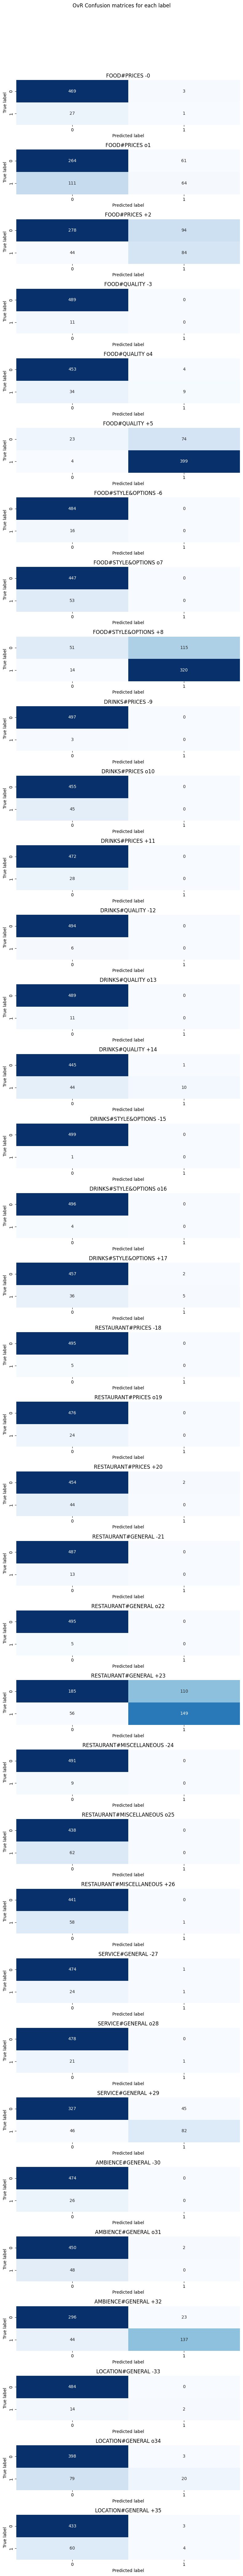

In [51]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

start = time.time()
labels = ytest_ml.columns
ytest_pred = clf0.predict(xtest_basecl_basef)
ytest_pred_formatted = mo2ml(mo2df(ytest_pred))
mcm = multilabel_confusion_matrix(ytest_ml, ytest_pred_formatted)

figure_width = 8
num_labels = len(labels)
height_per_subplot = 2.5

total_figure_height = height_per_subplot * num_labels
fig, axes = plt.subplots(len(labels), 1, figsize=(figure_width, total_figure_height))
fig.suptitle('OvR Confusion matrices for each label')

for i, (matrix, name) in enumerate(zip(mcm, labels)):
    ax=axes[i]
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(name + f'{i}')
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')

print("Total elapsed time = ", time.time() - start, "(seconds)")
plt.tight_layout(rect=[0,0.05,1,0.96])
plt.show()

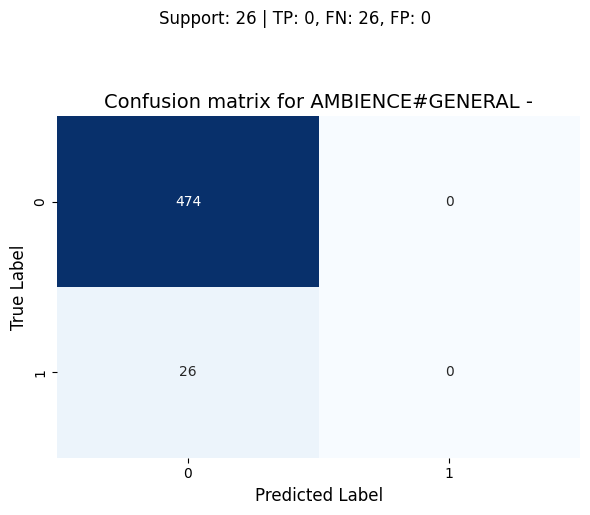

In [52]:
def plot_multilabel_matrix(ytrue, ypred, index, col_names=None):
    """
    Plot the confusion matrix for column[index]
    Args:
        ytrue: df type (36 cols)
        ypred: df type (36 cols)
        index: int type
        col_names: str type: column name 
    """
    col_names = ytrue.columns[index]
    ytrue_idx = np.asarray(ytrue[col_names])
    ypred_idx = np.asarray(ypred[col_names])
    mcm = multilabel_confusion_matrix(ytrue, ypred)
    conf_matrix = mcm[index]
    title = f"Confusion matrix for {col_names}"
    tn, fp, fn, tp = conf_matrix.ravel()

    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    support = tp + fn
    fig.suptitle(f"Support: {support} | TP: {tp}, FN: {fn}, FP: {fp}", fontsize=12, y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

ypred=mo2ml(mo2df(clf0.predict(xtest_basecl_basef)))
plot_multilabel_matrix(ytest_ml, ypred, 30)


In [53]:
clf1 = MOC(LinearSVC(random_state=5))
# advance clean up and basic feature extractor
start = time.time()
clf1.fit(xtrain_basef, ytrain_b)
print(f"fitting time for advance clean up and basic feature: {(time.time() - start ) / 60}")

print(quick_f1(ytrain_ml, clf1.predict(xtrain_basef)))
print(quick_f1(ydev_ml  , clf1.predict(xdev_basef)))
print(quick_f1(ytest_ml , clf1.predict(xtest_basef)))
print(evaluate(clf1, xtest_basef, ytest_b))

fitting time for advance clean up and basic feature: 0.014759798844655355
0.9989
0.6634
0.6119
              precision    recall  f1-score   support

           0       0.20      0.04      0.06        28
           1       0.58      0.43      0.50       175
           2       0.49      0.66      0.56       128
           3       0.00      0.00      0.00        11
           4       0.69      0.21      0.32        43
           5       0.84      0.99      0.91       403
           6       0.00      0.00      0.00        16
           7       0.00      0.00      0.00        53
           8       0.74      0.96      0.84       334
           9       0.00      0.00      0.00         3
          10       0.00      0.00      0.00        45
          11       0.00      0.00      0.00        28
          12       0.00      0.00      0.00         6
          13       0.00      0.00      0.00        11
          14       0.92      0.20      0.33        54
          15       0.00      0.00      0

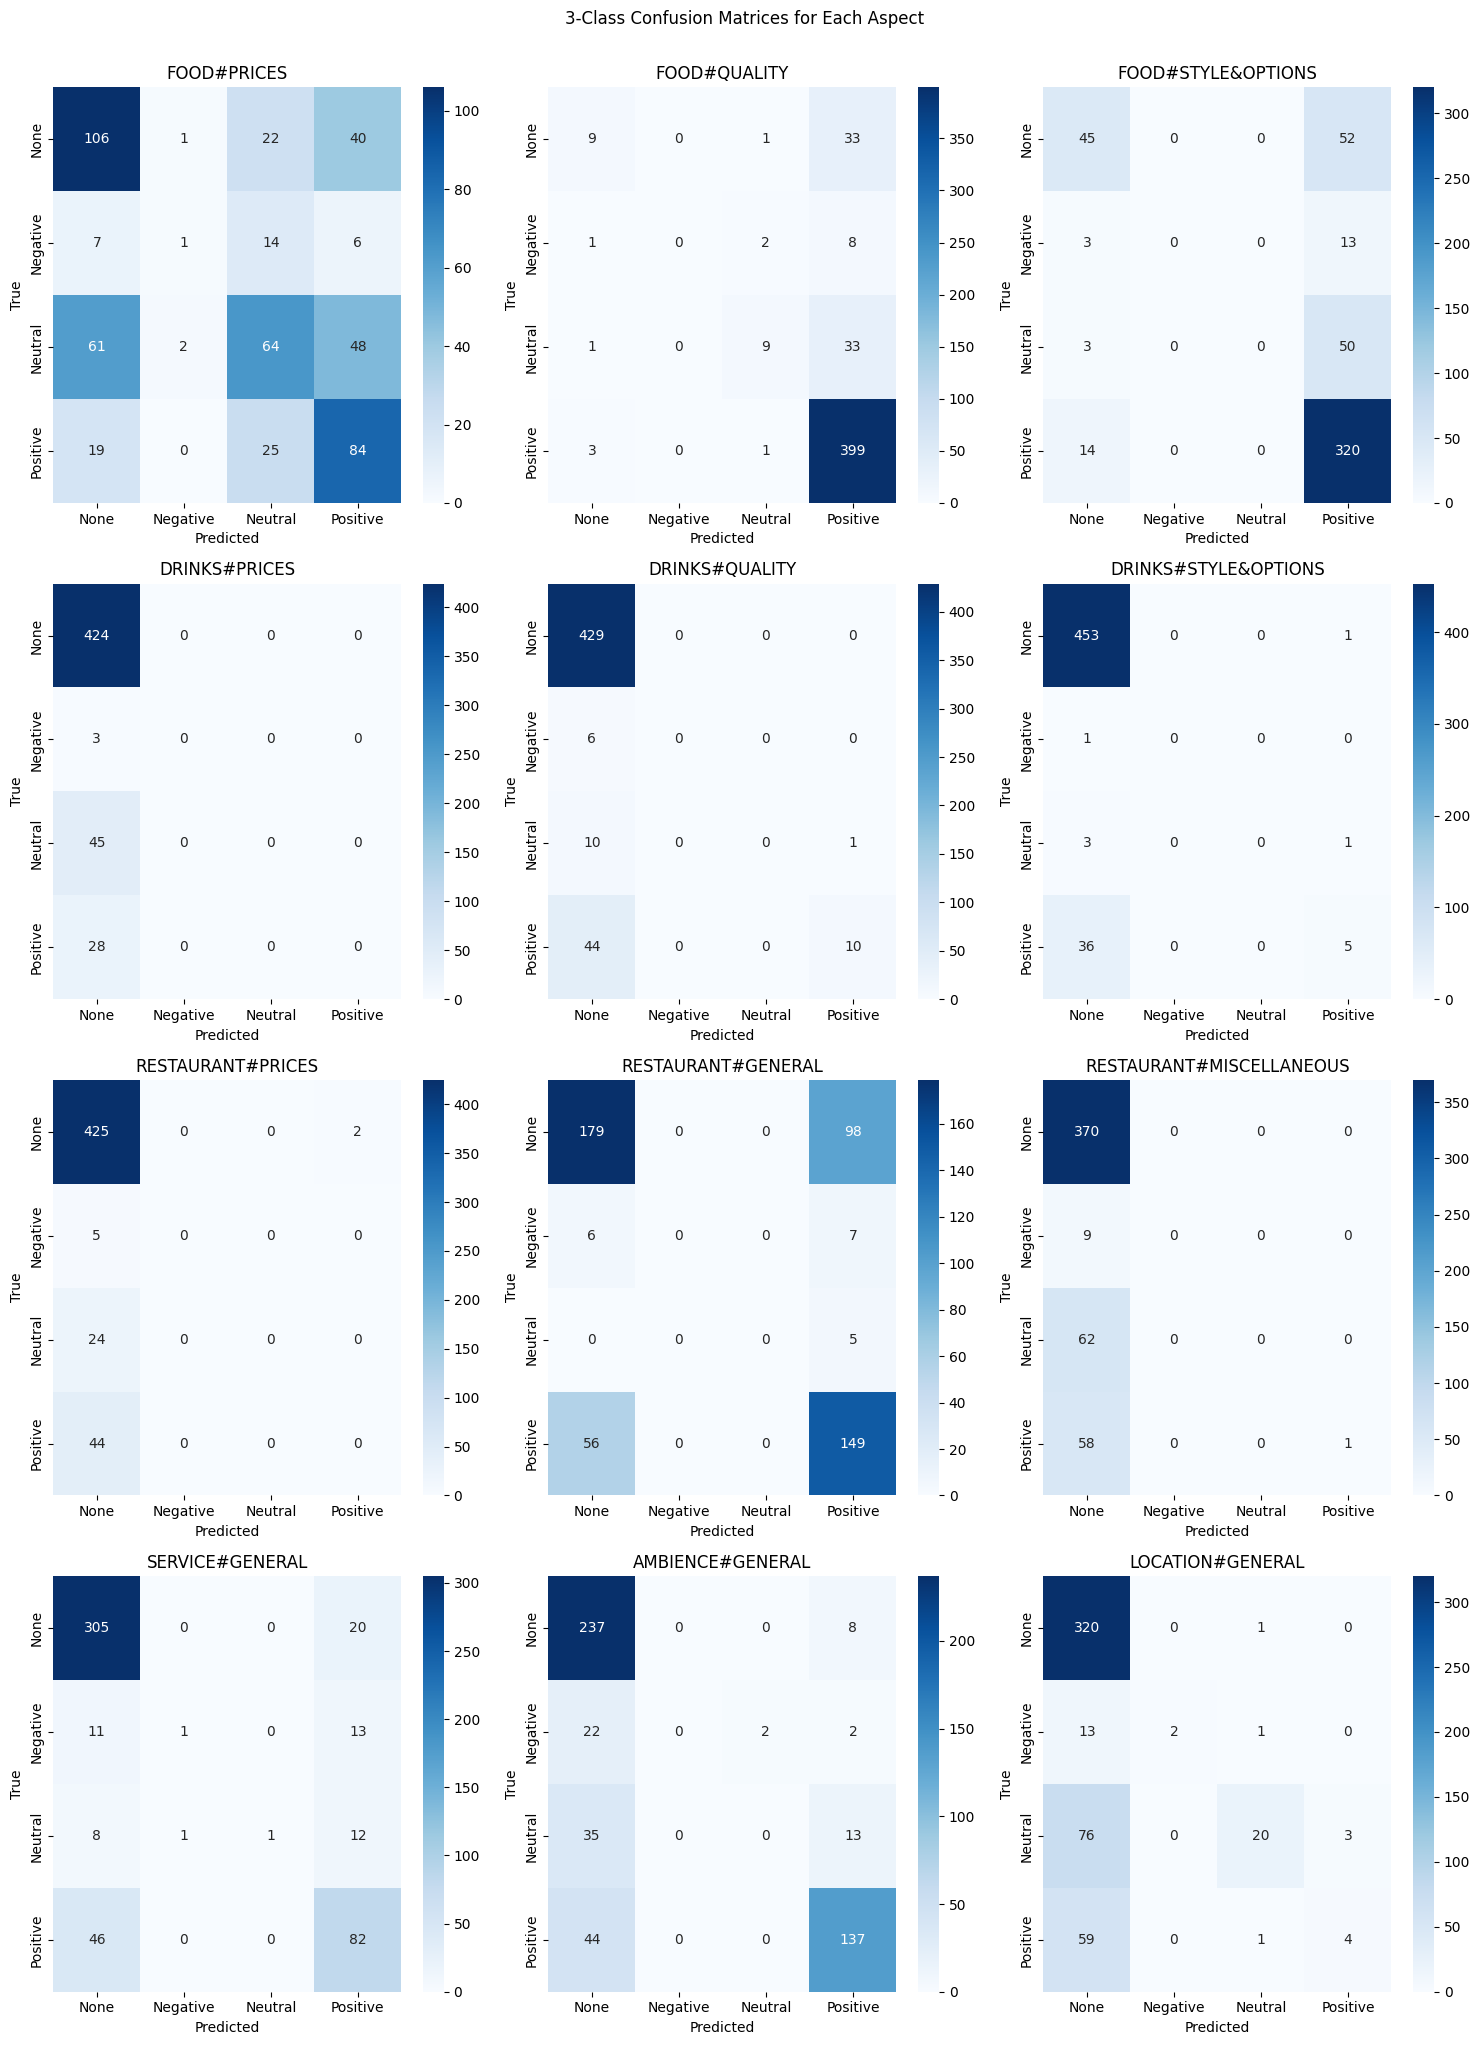

In [54]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions in original format (12 aspects with values 1,2,3)
ytest_pred_multioutput = clf0.predict(xtest_basecl_basef)
ytest_pred_df = mo2df(ytest_pred_multioutput)

# Create 3-class confusion matrices for each aspect
fig, axes = plt.subplots(4, 3, figsize=(15, 20))
axes = axes.flatten()

for i, aspect in enumerate(aspects):
    if i < len(axes):
        # Get true and predicted values for this aspect
        y_true_aspect = ytest_b[aspect]
        y_pred_aspect = ytest_pred_df[aspect]
        
        # Create confusion matrix
        cm = confusion_matrix(y_true_aspect, y_pred_aspect, labels=[0, 1, 2, 3])
        
        # Plot
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], 
                   xticklabels=['None', 'Negative', 'Neutral', 'Positive'],
                   yticklabels=['None', 'Negative', 'Neutral', 'Positive'])
        axes[i].set_title(f'{aspect}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('True')

# Hide unused subplots
for i in range(len(aspects), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.suptitle('3-Class Confusion Matrices for Each Aspect', y=1.02)
plt.show()

## Linear SVC hyperparameter tuning

In [55]:
import optuna
from optuna.samplers import TPESampler

In [56]:
def callback(study, trial):
    """Args:
        study: entire optimization process, it keeps track all trials and their performance
        trial: current trial being evaluated
    """
    if study.best_trial.number == trial.number:
        study.set_user_attr(key='best_model', value=trial.user_attrs['model'])
        

Note:
- Since `LinearSVC` learns a separate decision boundary for each class, the learned <strong> weights and biases</strong> for each classifier are **different**.
- However, all 12 classifiers <strong> share the same hyperparameters</strong> because **Optuna optimizes a single set of hyperparamters for the entire multi-class model.**

In [57]:
ytrain_b

,FOOD#PRICES,FOOD#QUALITY,FOOD#STYLE&OPTIONS,DRINKS#PRICES,DRINKS#QUALITY,DRINKS#STYLE&OPTIONS,RESTAURANT#PRICES,RESTAURANT#GENERAL,RESTAURANT#MISCELLANEOUS,SERVICE#GENERAL,AMBIENCE#GENERAL,LOCATION#GENERAL
0,0,2,2,0,0,0,0,0,0,0,0,0
1,2,3,3,0,0,0,2,3,0,1,3,0
2,3,3,3,0,0,0,0,3,3,3,1,1
3,0,3,3,0,0,0,0,3,0,0,0,0
4,0,3,3,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2956,0,3,0,0,0,0,0,0,0,0,0,0
2957,2,3,3,0,0,0,0,0,0,0,0,1
2958,0,0,0,0,0,0,0,3,3,0,0,0
2959,0,0,0,0,0,0,3,3,0,0,3,0


In [58]:
from sklearn.svm import LinearSVC

def linearSVC_objective(trial):
    params = dict(
        C=trial.suggest_float('C', 1e-9, 1e2, log=True), # logarithmic scale
        class_weight=trial.suggest_categorical('class_weight', ['balanced', None]),
        loss=trial.suggest_categorical('loss', ['hinge', 'squared_hinge']),
        max_iter=200,
        random_state=5
    )

    clf = MOC(LinearSVC(**params))
    clf.fit(xtrain_basef, ytrain_b)
    trial.set_user_attr('model', value=clf)

    y_pred = clf.predict(xdev_basef)
    return quick_f1(ydev_ml, y_pred)

sampler = TPESampler(seed=22)
linearSVC_study = optuna.create_study(
    sampler=sampler,
    direction='maximize'
)
linearSVC_study.optimize(linearSVC_objective, n_trials=50, callbacks=[callback])


clf2 = linearSVC_study.user_attrs['best_model']
# y_pred = clf2.predict(xtest_basef)

print(evaluate(clf2, xtest_basef, ytest_b))

print(f"train: {quick_f1(ytrain_ml, clf2.predict(xtrain_basef))}")
print(f"dev: {quick_f1(ydev_ml, clf2.predict(xdev_basef))}")
print(f"test: {quick_f1(ytest_ml, clf2.predict(xtest_basef))}")

print(clf2.estimators_[0].get_params)
print(linearSVC_study.best_params)

[I 2025-06-28 06:39:08,776] A new study created in memory with name: no-name-f2b57edb-697b-4e58-8967-9a76bd31ab4c
[I 2025-06-28 06:39:08,962] Trial 0 finished with value: 0.4855 and parameters: {'C': 1.9636582699290402e-07, 'class_weight': 'balanced', 'loss': 'hinge'}. Best is trial 0 with value: 0.4855.
[I 2025-06-28 06:39:09,227] Trial 1 finished with value: 0.4855 and parameters: {'C': 5.339536586472381e-06, 'class_weight': None, 'loss': 'squared_hinge'}. Best is trial 0 with value: 0.4855.
[I 2025-06-28 06:39:09,372] Trial 2 finished with value: 0.4855 and parameters: {'C': 1.3055563380836963e-09, 'class_weight': None, 'loss': 'hinge'}. Best is trial 0 with value: 0.4855.
[I 2025-06-28 06:39:09,515] Trial 3 finished with value: 0.4855 and parameters: {'C': 1.1682869614143264e-09, 'class_weight': None, 'loss': 'hinge'}. Best is trial 0 with value: 0.4855.
[I 2025-06-28 06:39:10,347] Trial 4 finished with value: 0.657 and parameters: {'C': 0.2804917948703948, 'class_weight': 'balance

              precision    recall  f1-score   support

           0       0.31      0.14      0.20        28
           1       0.54      0.51      0.53       175
           2       0.48      0.65      0.55       128
           3       0.00      0.00      0.00        11
           4       0.59      0.47      0.52        43
           5       0.88      0.96      0.92       403
           6       0.50      0.06      0.11        16
           7       0.00      0.00      0.00        53
           8       0.74      0.97      0.84       334
           9       0.00      0.00      0.00         3
          10       0.00      0.00      0.00        45
          11       0.50      0.04      0.07        28
          12       0.00      0.00      0.00         6
          13       0.00      0.00      0.00        11
          14       0.78      0.26      0.39        54
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         4
          17       0.75    

In [59]:
print(len(clf2.estimators_))
print(clf2.estimators_[0].coef_.shape)
print(xtrain_basef.shape)

12
(4, 32974)
(2961, 32974)


In [60]:
for i, estimator in enumerate(clf2.estimators_):
    print(f"Estimator {i}: coef_ shape = {estimator.coef_.shape}")

Estimator 0: coef_ shape = (4, 32974)
Estimator 1: coef_ shape = (4, 32974)
Estimator 2: coef_ shape = (4, 32974)
Estimator 3: coef_ shape = (4, 32974)
Estimator 4: coef_ shape = (4, 32974)
Estimator 5: coef_ shape = (4, 32974)
Estimator 6: coef_ shape = (4, 32974)
Estimator 7: coef_ shape = (4, 32974)
Estimator 8: coef_ shape = (4, 32974)
Estimator 9: coef_ shape = (4, 32974)
Estimator 10: coef_ shape = (4, 32974)
Estimator 11: coef_ shape = (4, 32974)


## Non-Linear SVM

In [61]:
xtrain_basef.shape

(2961, 32974)

In [62]:
# kernel SVM
import time

start = time.time()
from sklearn.svm import SVC

def svc_objective(trial):
    params = dict(
        class_weight=trial.suggest_categorical('class_weight', ['balanced', None]),
        kernel=trial.suggest_categorical('kernel', ['poly', 'rbf', 'sigmoid']),
        gamma=trial.suggest_categorical('gamma', ['auto', 'scale']),
        max_iter=300,
        random_state=5
    )

    clf0 = MOC(SVC(**params))
    clf0.fit(xtrain_basef, ytrain_b)
    trial.set_user_attr(key='model', value=clf0)

    y_pred = clf0.predict(xdev_basef)
    return quick_f1(ydev_ml, y_pred)

def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key='best_model', value=trial.user_attrs['model'])
    
sampler = TPESampler(seed=22)
SVC_study = optuna.create_study(
    sampler=sampler,
    direction='maximize'
)
SVC_study.optimize(svc_objective, n_trials=50, callbacks=[callback])

print(f'total elapsed time: {(time.time() - start) / 60}')

[I 2025-06-28 06:40:02,877] A new study created in memory with name: no-name-145a5e4f-5afa-468d-8f57-358ab2d0da37
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning:


total elapsed time: 30.40994597673416


In [63]:
clf_best = SVC_study.user_attrs['best_model']
# y_pred = clf_best.predict(xtest_basef)

print(evaluate(clf_best, xtest_basef, ytest_b))

print(f"train: {quick_f1(ytrain_ml, clf_best.predict(xtrain_basef))}")
print(f"dev: {quick_f1(ydev_ml, clf_best.predict(xdev_basef))}")
print(f"test: {quick_f1(ytest_ml, clf_best.predict(xtest_basef))}")

print(f"First estimator of MOC: {clf_best.estimators_[0].get_params()}")
print(f"Best hyperparameter for MOC: {SVC_study.best_params}")

              precision    recall  f1-score   support

           0       0.50      0.04      0.07        28
           1       0.47      0.43      0.45       175
           2       0.45      0.60      0.51       128
           3       0.00      0.00      0.00        11
           4       0.71      0.12      0.20        43
           5       0.83      0.99      0.91       403
           6       0.00      0.00      0.00        16
           7       0.00      0.00      0.00        53
           8       0.74      0.91      0.82       334
           9       0.00      0.00      0.00         3
          10       0.00      0.00      0.00        45
          11       0.00      0.00      0.00        28
          12       0.00      0.00      0.00         6
          13       0.00      0.00      0.00        11
          14       1.00      0.02      0.04        54
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         4
          17       1.00    

In [64]:
from sklearn.svm import SVC

def svc_objective(trial):
    params = dict(
        class_weight=trial.suggest_categorical('class_weight', ['balanced', None]),
        kernel=trial.suggest_categorical('kernel', ['poly', 'rbf', 'sigmoid']),
        gamma=trial.suggest_categorical('gamma', ['auto', 'scale']),
        max_iter=300,
        random_state=5
    )

    clf = MOC(SVC(**params))
    clf.fit(xtrain_basef, ytrain_b)
    trial.set_user_attr(key="model", value=clf)

    y_pred = clf.predict(xdev_basef)
    return quick_f1(ydev_ml, y_pred)

sampler = TPESampler(seed=22)
svc_study = optuna.create_study(direction='maximize')
svc_study.optimize(svc_objective, n_trials=10, callbacks=[callback])


clf3 = svc_study.user_attrs['best_model']

print(evaluate(clf3, xtest_basef, ytest_b))

print('train:', quick_f1(ytrain_ml, clf3.predict(xtrain_basef)))
print('dev:  ', quick_f1(ydev_ml  , clf3.predict(xdev_basef)))
print('test: ', quick_f1(ytest_ml , clf3.predict(xtest_basef)))

print(clf3.estimators_[0].get_params())
print(svc_study.best_params)

[I 2025-06-28 07:11:18,644] A new study created in memory with name: no-name-9defed02-b072-46f5-90af-89d0464755e8
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning:


              precision    recall  f1-score   support

           0       0.50      0.04      0.07        28
           1       0.47      0.43      0.45       175
           2       0.45      0.60      0.51       128
           3       0.00      0.00      0.00        11
           4       0.71      0.12      0.20        43
           5       0.83      0.99      0.91       403
           6       0.00      0.00      0.00        16
           7       0.00      0.00      0.00        53
           8       0.74      0.91      0.82       334
           9       0.00      0.00      0.00         3
          10       0.00      0.00      0.00        45
          11       0.00      0.00      0.00        28
          12       0.00      0.00      0.00         6
          13       0.00      0.00      0.00        11
          14       1.00      0.02      0.04        54
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         4
          17       1.00    

## Logistic Regression

In [65]:
from sklearn.linear_model import LogisticRegression
import time

start = time.time()
def logistic_objective(trial):
    params = dict(
        class_weight=trial.suggest_categorical('class_weight', ['balanced', None]),
        C=trial.suggest_float('C', 1e-5, 20),
        random_state=5,
        max_iter=200
    )    

    clf = MOC(LogisticRegression(**params))
    clf.fit(xtrain_basef, ytrain_b)
    trial.set_user_attr(key="model", value=clf)

    y_pred = clf.predict(xdev_basef)
    return quick_f1(ydev_ml, y_pred)

sampler = TPESampler(seed=22)
logistic_study = optuna.create_study(sampler=sampler, direction='maximize')
logistic_study.optimize(logistic_objective, n_trials=5, callbacks=[callback])


clf4 = logistic_study.user_attrs['best_model']

print(evaluate(clf4, xtest_basef, ytest_b))

print('train:', quick_f1(ytrain_ml, clf4.predict(xtrain_basef)))
print('dev:  ', quick_f1(ydev_ml  , clf4.predict(xdev_basef)))
print('test:', quick_f1(ytest_ml  , clf4.predict(xtest_basef)))

print(clf4.estimators_[0].get_params())
print(logistic_study.best_params)

print(f"total elapsed time: {(time.time() - start) / 60} (minutes)")

[I 2025-06-28 07:18:05,553] A new study created in memory with name: no-name-b5c05939-92de-402b-9900-dea71b122305
[I 2025-06-28 07:18:14,158] Trial 0 finished with value: 0.6604 and parameters: {'class_weight': None, 'C': 8.41076650090714}. Best is trial 0 with value: 0.6604.
[I 2025-06-28 07:18:22,377] Trial 1 finished with value: 0.6669 and parameters: {'class_weight': 'balanced', 'C': 6.777285823434402}. Best is trial 1 with value: 0.6669.
[I 2025-06-28 07:18:30,232] Trial 2 finished with value: 0.6587 and parameters: {'class_weight': None, 'C': 4.408098128709346}. Best is trial 1 with value: 0.6669.
[I 2025-06-28 07:18:38,580] Trial 3 finished with value: 0.6654 and parameters: {'class_weight': 'balanced', 'C': 11.224078321223027}. Best is trial 1 with value: 0.6669.
[I 2025-06-28 07:18:46,636] Trial 4 finished with value: 0.6649 and parameters: {'class_weight': 'balanced', 'C': 3.7822352140976876}. Best is trial 1 with value: 0.6669.


              precision    recall  f1-score   support

           0       0.40      0.21      0.28        28
           1       0.55      0.58      0.56       175
           2       0.50      0.66      0.57       128
           3       0.00      0.00      0.00        11
           4       0.52      0.53      0.53        43
           5       0.89      0.93      0.91       403
           6       0.50      0.06      0.11        16
           7       0.25      0.06      0.09        53
           8       0.75      0.95      0.84       334
           9       0.00      0.00      0.00         3
          10       0.44      0.09      0.15        45
          11       0.33      0.07      0.12        28
          12       0.00      0.00      0.00         6
          13       0.00      0.00      0.00        11
          14       0.59      0.43      0.49        54
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         4
          17       0.43    

## Random Forest

In [66]:
from sklearn.ensemble import RandomForestClassifier as RFC
import time

start = time.time()
def rfc_objective(trial):
    params = dict(
        bootstrap=trial.suggest_categorical('bootstrap', [True, False]),
        max_depth=trial.suggest_categorical('max_depth', [None, 20, 40, 60, 80, 100]),
        max_features=trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        n_estimators=trial.suggest_int('n_estimators', 100, 200, step=20),
        n_jobs=-1,
        random_state=5
    )

    clf = RFC(**params)
    clf.fit(xtrain_basef, ytrain_b)
    trial.set_user_attr(key="model", value=clf)
    
    y_pred = clf.predict(xdev_basef)
    return quick_f1(ydev_ml, y_pred)


sampler = TPESampler(seed=22)
rfc_study = optuna.create_study(sampler=sampler, direction='maximize')
rfc_study.optimize(rfc_objective, n_trials=20, callbacks=[callback])


clf5 = rfc_study.user_attrs['best_model']

print(evaluate(clf5, xtest_basef, ytest_b))

print('train:', quick_f1(ytrain_ml, clf5.predict(xtrain_basef)))
print('dev:  ', quick_f1(ydev_ml  , clf5.predict(xdev_basef)))
print('test:', quick_f1(ytest_ml  , clf5.predict(xtest_basef)))

print(clf5.get_params())
print(rfc_study.best_params)
print(f"total elapsed time: {(time.time() - start) / 60} (minutes)")

[I 2025-06-28 07:18:46,853] A new study created in memory with name: no-name-b1e83bf1-41ab-4c50-980e-6e5133ec4a73
[I 2025-06-28 07:18:47,502] Trial 0 finished with value: 0.4877 and parameters: {'bootstrap': False, 'max_depth': 20, 'max_features': 'log2', 'n_estimators': 100}. Best is trial 0 with value: 0.4877.
[I 2025-06-28 07:18:49,967] Trial 1 finished with value: 0.5185 and parameters: {'bootstrap': False, 'max_depth': 80, 'max_features': 'log2', 'n_estimators': 180}. Best is trial 1 with value: 0.5185.
[I 2025-06-28 07:18:52,174] Trial 2 finished with value: 0.5193 and parameters: {'bootstrap': False, 'max_depth': 100, 'max_features': 'log2', 'n_estimators': 100}. Best is trial 2 with value: 0.5193.
[I 2025-06-28 07:18:55,912] Trial 3 finished with value: 0.5477 and parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'log2', 'n_estimators': 100}. Best is trial 3 with value: 0.5477.
[I 2025-06-28 07:19:08,601] Trial 4 finished with value: 0.5982 and parameters: {'b

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.42      0.06      0.10       175
           2       0.52      0.35      0.42       128
           3       0.00      0.00      0.00        11
           4       0.00      0.00      0.00        43
           5       0.81      1.00      0.89       403
           6       0.00      0.00      0.00        16
           7       0.00      0.00      0.00        53
           8       0.70      0.98      0.82       334
           9       0.00      0.00      0.00         3
          10       0.00      0.00      0.00        45
          11       0.00      0.00      0.00        28
          12       0.00      0.00      0.00         6
          13       0.00      0.00      0.00        11
          14       0.00      0.00      0.00        54
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         4
          17       0.00    

## TwoStageSimple

In [67]:
clf6 = TwoStageSimple(MOC(LinearSVC(**clf2.estimators_[0].get_params())),
                      MOC(LinearSVC(**clf2.estimators_[0].get_params())))
clf6.fit(xtrain_basef, ytrain_a, ytrain_b)

print(evaluate(clf6, xtest_basef, ytest_b))

print('train:', quick_f1(ytrain_ml, clf6.predict(xtrain_basef)))
print('dev:  ', quick_f1(ydev_ml  , clf6.predict(xdev_basef)))
print('test:', quick_f1(ytest_ml  , clf6.predict(xtest_basef)))

              precision    recall  f1-score   support

           0       0.33      0.14      0.20        28
           1       0.52      0.55      0.54       175
           2       0.48      0.68      0.56       128
           3       0.00      0.00      0.00        11
           4       0.56      0.21      0.31        43
           5       0.86      0.95      0.90       403
           6       1.00      0.06      0.12        16
           7       0.00      0.00      0.00        53
           8       0.73      0.96      0.83       334
           9       0.00      0.00      0.00         3
          10       0.55      0.13      0.21        45
          11       0.29      0.14      0.19        28
          12       0.00      0.00      0.00         6
          13       0.00      0.00      0.00        11
          14       0.64      0.43      0.51        54
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         4
          17       0.56    

In [68]:
clf7 = TwoStageSimple(MOC(SVC(**clf3.estimators_[0].get_params())),
                      MOC(SVC(**clf3.estimators_[0].get_params())))
clf7.fit(xtrain_basef, ytrain_a, ytrain_b)

print(evaluate(clf7, xtest_basef, ytest_b))

print('train:', quick_f1(ytrain_ml, clf7.predict(xtrain_basef)))
print('dev:  ', quick_f1(ydev_ml  , clf7.predict(xdev_basef)))
print('test: ', quick_f1(ytest_ml , clf7.predict(xtest_basef)))

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



              precision    recall  f1-score   support

           0       0.07      0.18      0.11        28
           1       0.40      0.01      0.02       175
           2       0.28      0.62      0.39       128
           3       0.00      0.00      0.00        11
           4       1.00      0.05      0.09        43
           5       0.83      1.00      0.91       403
           6       0.00      0.00      0.00        16
           7       0.30      0.06      0.10        53
           8       0.71      0.86      0.78       334
           9       0.00      0.00      0.00         3
          10       0.00      0.00      0.00        45
          11       0.00      0.00      0.00        28
          12       0.00      0.00      0.00         6
          13       0.00      0.00      0.00        11
          14       1.00      0.06      0.11        54
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         4
          17       1.00    

In [69]:
clf8 = TwoStageSimple(MOC(LogisticRegression(**clf4.estimators_[0].get_params())),
                      MOC(LogisticRegression(**clf4.estimators_[0].get_params())))
clf8.fit(xtrain_basef, ytrain_a, ytrain_b)

print(evaluate(clf8, xtest_basef, ytest_b))

print('train:', quick_f1(ytrain_ml, clf8.predict(xtrain_basef)))
print('dev:  ', quick_f1(ydev_ml  , clf8.predict(xdev_basef)))
print('test:', quick_f1(ytest_ml  , clf8.predict(xtest_basef)))

              precision    recall  f1-score   support

           0       0.37      0.25      0.30        28
           1       0.52      0.57      0.54       175
           2       0.47      0.64      0.54       128
           3       0.00      0.00      0.00        11
           4       0.48      0.30      0.37        43
           5       0.87      0.94      0.90       403
           6       1.00      0.06      0.12        16
           7       0.19      0.06      0.09        53
           8       0.73      0.95      0.83       334
           9       0.00      0.00      0.00         3
          10       0.39      0.16      0.22        45
          11       0.20      0.14      0.17        28
          12       0.00      0.00      0.00         6
          13       0.00      0.00      0.00        11
          14       0.51      0.39      0.44        54
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         4
          17       0.46    

In [70]:
clf9 = TwoStageSimple(RFC(**clf5.get_params()),
                      RFC(**clf5.get_params()))
clf9.fit(xtrain_basef, ytrain_a, ytrain_b)

print(evaluate(clf9, xtest_basef, ytest_b))

print('train:', quick_f1(ytrain_ml, clf9.predict(xtrain_basef)))
print('dev:  ', quick_f1(ydev_ml  , clf9.predict(xdev_basef)))
print('test:', quick_f1(ytest_ml  , clf9.predict(xtest_basef)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.51      0.21      0.29       175
           2       0.42      0.59      0.49       128
           3       0.00      0.00      0.00        11
           4       0.00      0.00      0.00        43
           5       0.81      1.00      0.89       403
           6       0.00      0.00      0.00        16
           7       0.00      0.00      0.00        53
           8       0.69      0.99      0.81       334
           9       0.00      0.00      0.00         3
          10       0.00      0.00      0.00        45
          11       0.00      0.00      0.00        28
          12       0.00      0.00      0.00         6
          13       0.00      0.00      0.00        11
          14       0.00      0.00      0.00        54
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         4
          17       0.00    

## TwoStageAdvanced

In [71]:
clf10 = TwoStageAdvanced(MOC(LinearSVC(**clf2.estimators_[0].get_params())),
                         MOC(LinearSVC(**clf2.estimators_[0].get_params())))
clf10.fit(xtrain_a, xtrain_b, ytrain_a, ytrain_b)

yb_true  = mo2ml(ytest_b)

yb_pred  = mo2df(clf10.predict(xtest_a, xtest_b))
yb_pred  = mo2ml(yb_pred)

print(classification_report(yb_true, yb_pred, zero_division=0))

print('train:', quick_f1(ytrain_ml, clf10.predict(xtrain_a, xtrain_b)))
print('dev:  ', quick_f1(ydev_ml  , clf10.predict(xdev_a, xdev_b)))
print('test:', quick_f1(ytest_ml  , clf10.predict(xtest_a, xtest_b)))

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



              precision    recall  f1-score   support

           0       0.25      0.11      0.15        28
           1       0.53      0.39      0.45       175
           2       0.42      0.55      0.48       128
           3       0.00      0.00      0.00        11
           4       0.59      0.30      0.40        43
           5       0.86      0.94      0.90       403
           6       0.00      0.00      0.00        16
           7       0.00      0.00      0.00        53
           8       0.74      0.87      0.80       334
           9       0.00      0.00      0.00         3
          10       0.38      0.07      0.11        45
          11       0.10      0.07      0.08        28
          12       0.00      0.00      0.00         6
          13       0.00      0.00      0.00        11
          14       0.57      0.44      0.50        54
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         4
          17       0.42    

# My Experiment

In [72]:
from underthesea import pos_tag, word_tokenize
from scipy import sparse
from sklearn.feature_extraction.text import (CountVectorizer,
                                             TfidfTransformer,
                                             TfidfVectorizer)

from sklearn.pipeline import make_pipeline

class MyFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()

        self.for_phase_a = True # a mode flag

        # POS tags encoding
        self.allow_tags = {tag: i for i, tag in enumerate('NVA', 1)}

    def _nva_extractor(self, X):
        """
        Extract noun, verb, adjective tokens and tags
        Args:
            X: dataframe: each row is a review (string type)
        """
        reviews = []
        # for each review, we only extract token that is NVA pos_tag
        for x in X:
            # pos_tag returns a tuple ('word', 'tag')
            review = [item for item in pos_tag(x) \
                      if item[1] in self.allow_tags]
            reviews.append(review)
        return reviews

    # postag vectorizer
    def _postag_vtrz(self, reviews):
        """
        Convert pos tags to a feature matrix
        """
        vocab = self.tfidf_nva[0].vocabulary #tfidf_nva is a pipeline, tf_idf_nva[0] is a countVectorizer
        features = np.zeros((len(reviews), len(vocab)))
        for review, feature in zip(reviews, features):
            for token, tag in review:
                try:
                    feature[vocab[token]] = self.allow_tags[tag]
                except KeyError:
                    pass
        return features

    def fit(self, X, y=None):
        # change each review into list of ('word', 'pos_tag')
        reviews = self._nva_extractor(X)

        # Create the vocabulary
        vocab = {item[0] for review in reviews
                 for item in review}
        # a dictionary of word where words are keys and values are their indexes
        vocab = {word: i for i, word in enumerate(vocab)}

        # Tfidf for noun, verb, adjective tokens
        # a word must appear in at least 2 documents to be included in vocab
        # a word will be ignored if it appears more than 90% of the documents
        count_nva = CountVectorizer(tokenizer=word_tokenize,
                                    vocabulary=vocab,
                                    min_df=2, max_df=0.9)
        tfidf_vec = TfidfTransformer()
        self.tfidf_nva = make_pipeline(count_nva, tfidf_vec).fit(X)

        # 1, 2, 3 grams
        self.tfidf_123 = TfidfVectorizer(ngram_range=(1, 3),
                                         min_df=2, max_df=0.9).fit(X)
        
        # 2, 3 grams
        self.tfidf_23 = TfidfVectorizer(ngram_range=(2, 3),
                                        min_df=2, max_df=0.9).fit(X)

        return self

    def transform(self, X):
        reviews = self._nva_extractor(X)

        if self.for_phase_a:
            features = [self.tfidf_123.transform(X),
                        self.tfidf_nva.transform(X),
                        self._postag_vtrz(reviews)] 
            # keeps the same rows, add columns of those matrix to each other
            return sparse.hstack(features)

        features = [self.tfidf_23.transform(X),
                    self.tfidf_nva.transform(X),
                    [['!' in text or '?' in text] for text in X]]
        return sparse.hstack(features)

# Export model

In [73]:
# from sklearn.pipeline import make_pipeline
# import joblib

# pipe = make_pipeline(TextCleaner(), vectorizer, clf4)
# joblib.dump(pipe, 'pipe.joblib')

# Draft

## Unicode normalization

In [74]:
import unicodedata

dựng_sẵn = '\u1EA0'
tổ_hợp   = '\u0041\u0323'

print(dựng_sẵn, tổ_hợp)
print(dựng_sẵn == tổ_hợp)

print('-'*10)

dựng_sẵn = unicodedata.normalize('NFC', dựng_sẵn)
tổ_hợp   = unicodedata.normalize('NFC', tổ_hợp)

print(dựng_sẵn, tổ_hợp)
print(dựng_sẵn == tổ_hợp)

Ạ Ạ
False
----------
Ạ Ạ
True


## Test TextCleaner class

In [75]:
texts = ['K khí trong lành. đồ ăn hong ngon, thức uống  K tồi; 🥙🌮',
         'khung cảnh xinh đẹp',
         'khuyến mãi cực sốc giả chỉ 1000 đồng',
         '200k quá mắc',
         'món ăn này mắc quá tới 200k lận. ngày 23/3/2000 😴',
         'mua 100.000vnd',
         'bán 1,000,000 d. 5 cái bành xèo tốn 500k',
         'bán 1.000.000 d. 5 cái bành xèo tốn 500k %^^4',
         'món ăn này có giá 10 lít',
         'món ăn này tận 100 nghìn đồng',
         'bán 1.000đ',
         'quán này có giá trung bình từ 100k-200k 😛',
         'quán này có giá trung bình từ 100-200k 😫',
         '#mắc #food',
         'bàn ghế sạch đẹp, thái độ nhân viên ok#restaurant 😍',
         '#tiktok ở nhà vẫn vui',
         '# birthday ngày mai có tiệc ^^',
         'aslkdhlakd#tiktok#learn asljdalskjd',
         '#tiktok   #learn',
         '#hastag alskjdlasjd #hastag asdsadas #hastag 😁',
         '#123&456',
         '#!?@!']

cleaner = TextCleaner()
for t in cleaner.fit_transform(texts):
    print(t.strip())

không khí trong lành đồ ăn hong ngon thức uống  không tồi
khung cảnh xinh đẹp
khuyến mãi cực sốc giả chỉ giátiền
giátiền quá mắc
món ăn này mắc quá tới giátiền lận ngày 2332000
mua giátiền
bán giátiền 5 cái bành xèo tốn giátiền
bán giátiền 5 cái bành xèo tốn giátiền 4
món ăn này có giá 10 lít
món ăn này tận giátiền
bán giátiền
quán này có giá trung bình từ giátiềngiátiền
quán này có giá trung bình từ 100giátiền
hashtag hashtag
bàn ghế sạch đẹp thái độ nhân viên okhashtag
hashtag ở nhà vẫn vui
birthday ngày mai có tiệc
aslkdhlakdhashtag asljdalskjd
hashtag   hashtag
hashtag alskjdlasjd hashtag asdsadas hashtag
hashtag
hashtag


## Precision-Recall-F1

In [76]:
tmp1 = ydev_ml
tmp2 = mo2ml(mo2df(clf0.predict(Xdev)))
print(precision_score(tmp1, tmp2, average='micro'))
print(recall_score(tmp1, tmp2, average='micro'))
print(f1_score(tmp1, tmp2, average='micro'))
print()
print(precision_score(tmp1, tmp2, average='macro', zero_division=0))
print(recall_score(tmp1, tmp2, average='macro', zero_division=0))
print(f1_score(tmp1, tmp2, average='macro', zero_division=0))

ValueError: could not convert string to float: '- 60k/1con- Tu hài to, siêu béo siêu ngon, nướng mỡ hành thơm phức, béo ngậy- Đĩa tu hài đem ra nóng hổi, gắp 1 miếng vào miệng kích thích vi giác kinh khủng- 1 con to đến mức họ phải cắt ra làm đôi, ăn nửa con đầy ý miệng luôn ý. Mà giá đó cho 1 con tu hài ngon như vậy là quá rẻ!'

In [ ]:
def my_prec(target, predict, average='micro'):
    if average == 'micro':
        return (target & predict).values.sum() / predict.values.sum()
    return ((target & predict).sum() / predict.sum()).fillna(0).mean()

def my_reca(target, predict, average='micro'):
    if average == 'micro':
        return (target & predict).values.sum() / target.values.sum()
    return ((target & predict).sum() / target.sum()).fillna(0).mean()

def my_ftes(target, predict, average='micro'):
    if average == 'macro':
        p = ((target & predict).sum() / predict.sum()).fillna(0)
        r = ((target & predict).sum() / target.sum()).fillna(0)
        return (2*p*r / (p+r)).fillna(0).mean()
    else:
        p = my_prec(target, predict)
        r = my_reca(target, predict)
        return 2*p*r / (p+r)

print(my_prec(tmp1, tmp2))
print(my_reca(tmp1, tmp2))
print(my_ftes(tmp1, tmp2))
print()
print(my_prec(tmp1, tmp2, average='macro'))
print(my_reca(tmp1, tmp2, average='macro'))
print(my_ftes(tmp1, tmp2, average='macro'))